#### 환경설정

##### 1. Wandb

In [61]:
import wandb

# wandb 로그인
wandb.login(key="2fb604788cd6eed5aafafcc8d13a6aaa7737ac71")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/HyeonSeok/.netrc


True

##### 2. 라이브러리 로드

In [62]:

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
import os
import math
import random
import pickle
import wandb
from tqdm import tqdm
from datetime import datetime
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import torchvision
import torchvision.models as models
from torch import Tensor
from torchsummary import summary
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.manifold import TSNE

##### 3. 경로 설정

In [64]:
ROOT = "/home/HyeonSeok/BOAZ-Chungzins/data/raw"
CHECKPOINT_PATH = "/home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint"
PICKLE_PATH = "/home/HyeonSeok/BOAZ-Chungzins/save_path/pickle"
text = "/home/HyeonSeok/BOAZ-Chungzins/data/metadata/train_test_split.txt"

##### 4. Seed 설정

In [65]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

seed_everything(42) # Seed 고정

## 1. Data Load

#### 1.1 Data Load

In [66]:
# WAV 파일이 있는 디렉토리 경로
data_dir = ROOT
txt_dir = ROOT

df = pd.read_csv(text, sep='\t', header=None)

# 컬럼 이름 변경
df.columns = ['filename', 'set']

# train, test split
train_df = df[df['set'] == 'train']
test_df = df[df['set'] == 'test']

# filename list
train_list = sorted(train_df['filename'].tolist())
test_list = sorted(test_df['filename'].tolist())

print(f'Train :{len(train_list)}, Test: {len(test_list)}, Total: {len(train_list) + len(test_list)}')

Train :539, Test: 381, Total: 920


#### 1.2 Pretext-Finetune Split

In [67]:
# shuffle train data
df_shuffled = train_df.sample(frac=1, random_state=42)

# split ratio
train_size = int(len(df_shuffled))

# pretrain, finetune split
pretrain_df = df_shuffled[:train_size]
finetune_df = pretrain_df

# filename list (pretext_list -> pretrain list)
pretrain_list = sorted(pretrain_df['filename'].tolist())
finetune_list = sorted(finetune_df['filename'].tolist())

# patient id list
pretrain_patient_list = []
for filename in pretrain_list:
    number = int(filename.split('_')[0])
    pretrain_patient_list.append(number)

finetune_patient_list = []
for filename in finetune_list:
    number = int(filename.split('_')[0])
    finetune_patient_list.append(number)

pretrain_patient_counts = pd.Series(pretrain_patient_list).value_counts()
finetune_patient_counts = pd.Series(finetune_patient_list).value_counts()

print(f"[Pretrain] 환자 수: {len(pretrain_patient_counts.index)}, 샘플 수: {pretrain_patient_counts.sum()}")
print(f"[Finetune] 환자 수: {len(finetune_patient_counts.index)}, 샘플 수: {finetune_patient_counts.sum()}")

[Pretrain] 환자 수: 79, 샘플 수: 539
[Finetune] 환자 수: 79, 샘플 수: 539


## 2. Data Preprocessing

#### 2.1 Args

        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)

In [68]:
class Args:
    # Audio & Spectrogram
    target_sr = 16000    # 4KHz
    frame_size = 1024
    hop_length = 512    # frame_size 절반
    n_mels = 64
    target_sec = 8

    # Augmentation
    time_mask_param = 0.5
    freq_mask_param = 0.5

    # Train
    lr = 0.001 # adamw - 0.03
    warm = True                     # warm-up 사용 여부
    warm_epochs = 10                # warm-up 적용할 초기 epoch 수
    warmup_from = lr * 0.1          # warm-up 시작 learning rate (보통 lr의 10%)
    warmup_to = lr

    batch_size = 128
    workers = 2
    epochs = 200
    weight_decay = 1e-4

    resume = None
    schedule=[120, 160] # schedule

    # MLS
    K = 512
    momentum = 0.999
    T = 0.07
    dim_prj = 128
    top_k = 20
    lambda_bce = 0.3
    out_dim = 2048

    # Linear Evaluation
    ft_epochs = 3

    # etc
    gpu = 0
    data = "./data_path"
    seed=42

args = Args()

#### 2.2 Utils (func)

In [69]:
import torch.nn.functional as F
import random

# cycle의 클래스를 추출
def get_class(cr, wh):
    if cr == 1 and wh == 1:
        return 3
    elif cr == 0 and wh == 1:
        return 2
    elif cr == 1 and wh == 0:
        return 1
    elif cr == 0 and wh == 0:
        return 0
    else:
        return -1

# Mel Spectrogram 생성 ( sr=4KHz, frame_size=1024, hop_length=512, n_mels=128 )
# def generate_mel_spectrogram(waveform, sample_rate, frame_size, hop_length, n_mels):
#     if hop_length is None:
#         hop_length = frame_size // 2
#     mel_spec_transform = T.MelSpectrogram(
#         sample_rate=sample_rate,
#         n_fft=frame_size,
#         hop_length=hop_length,
#         n_mels=n_mels,
#         f_min=50,       # 논문 기준 주파수 범위 하한
#         f_max=2000      # 논문 기준 주파수 범위 상한
#     )
#     mel_spectrogram = mel_spec_transform(waveform)
#     mel_db = T.AmplitudeToDB()(mel_spectrogram)
    
#     # dB 스케일에서 매우 낮은 값은 0으로 마스킹
#     mel_db[mel_db <= -100.0] = 0.0
    
#     return mel_db

# 256 맟춰주기
def generate_mel_spectrogram(waveform, sample_rate, frame_size, hop_length, n_mels):
    if hop_length is None:
        hop_length = frame_size // 2

    mel_spec_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=frame_size,
        hop_length=hop_length,
        n_mels=n_mels,
        f_min=50,
        f_max=2000
    )
    mel_spectrogram = mel_spec_transform(waveform)
    mel_db = T.AmplitudeToDB()(mel_spectrogram)

    # dB 스케일에서 매우 낮은 값은 0으로 마스킹
    mel_db[mel_db <= -100.0] = 0.0

    # 🔧 가운데 padding 적용
    target_frames = 256
    current_frames = mel_db.shape[-1]
    if current_frames < target_frames:
        pad_total = target_frames - current_frames
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        mel_db = F.pad(mel_db, (pad_left, pad_right))  # center padding
    elif current_frames > target_frames:
        # 가운데 자르기
        start = (current_frames - target_frames) // 2
        mel_db = mel_db[:, :, start:start + target_frames]

    return mel_db

# Cycle Repeat 또는 Crop
def repeat_or_truncate_segment(mel_segment, target_frames):
    current_frames = mel_segment.shape[-1]
    if current_frames >= target_frames:
        return mel_segment[:, :, :target_frames]
    else:
        repeat_ratio = math.ceil(target_frames / current_frames)
        mel_segment = mel_segment.repeat(1, 1, repeat_ratio)
        return mel_segment[:, :, :target_frames]

# def preprocess_waveform_segment(waveform, unit_length):

#     """unit_length 기준으로 waveform을 repeat + padding 또는 crop하여 길이 정규화"""
#     waveform = waveform.squeeze(0)  # (1, L) → (L,) 로 바꿔도 무방
#     length_adj = unit_length - len(waveform)

#     if length_adj > 0:
#         # waveform이 너무 짧은 경우 → repeat + zero-padding
#         half_unit = unit_length // 2

#         if length_adj < half_unit:
#             # 길이 차이가 작으면 단순 padding
#             half_adj = length_adj // 2
#             waveform = F.pad(waveform, (half_adj, length_adj - half_adj))
#         else:
#             # 반복 후 부족한 부분 padding
#             repeat_factor = unit_length // len(waveform)
#             waveform = waveform.repeat(repeat_factor)[:unit_length]
#             remaining = unit_length - len(waveform)
#             half_pad = remaining // 2
#             waveform = F.pad(waveform, (half_pad, remaining - half_pad))
#     else:
#         # waveform이 너무 길면 앞쪽 1/4 내에서 랜덤 crop
#         length_adj = len(waveform) - unit_length
#         start = random.randint(0, length_adj // 4)
#         waveform = waveform[start:start + unit_length]

#     return waveform.unsqueeze(0)  # 다시 (1, L)로

# 논문 기반: Circular padding 방식 적용
# - waveform이 짧은 경우: circular padding으로 8초 길이 맞춤
# - waveform이 긴 경우: 앞쪽 25% 범위 내에서 랜덤 crop
def preprocess_waveform_segment(waveform, unit_length):
    """
    논문 기반: Circular padding 적용
    - waveform이 짧은 경우: circular padding으로 8초 길이 맞춤 (단, pad_len이 한 바퀴 이상 돌지 않도록 제한)
    - waveform이 긴 경우: 앞쪽 25% 범위 내에서 랜덤 crop
    """
    waveform = waveform.squeeze(0)  # (1, L) → (L,)
    current_len = waveform.size(0)

    if current_len < unit_length:
        pad_len = unit_length - current_len

        # torch circular pad 한계: pad_len < current_len
        if pad_len >= current_len and current_len > 0:
            # 여러 번 반복하여 붙이기
            repeat_factor = (pad_len // current_len) + 1
            extended = waveform.repeat(repeat_factor + 1)
            waveform = extended[:unit_length]
        else:
            # 일반적인 circular pad 적용
            waveform = waveform.unsqueeze(0)  # (L,) → (1, L)
            waveform = F.pad(waveform, (0, pad_len), mode='circular')
            waveform = waveform.squeeze(0)    # (1, L+pad) → (L+pad,)

    elif current_len > unit_length:
        max_start = max(0, current_len - unit_length)
        start = random.randint(0, max_start // 4)
        waveform = waveform[start:start + unit_length]

    return waveform.unsqueeze(0)  # (L,) → (1, L)


# 데이터 Spec Augmentation ( 0~80% Random Masking )
def apply_spec_augment(mel_segment):

    M = mel_segment.shape[-1]
    F = mel_segment.shape[-2]

    # torchaudio의 마스킹은 0부터 mask_param까지 균등분포에서 랜덤하게 길이를 선택
    time_masking = T.TimeMasking(time_mask_param=int(M * 0.8))
    freq_masking = T.FrequencyMasking(freq_mask_param=int(F * 0.8) )

    aug1 = freq_masking(mel_segment.clone())
    aug2 = time_masking(mel_segment.clone())
    aug3 = freq_masking(time_masking(mel_segment.clone()))

    return aug1, aug2, aug3

# Waveform resample
def resample_waveform(waveform, orig_sr, target_sr=args.target_sr):
    if orig_sr != target_sr:
        resampler = torchaudio.transforms.Resample(
            orig_freq=orig_sr,
            new_freq=target_sr
        )
        return resampler(waveform), target_sr
    return waveform, orig_sr

# Normalize - Mean/Std
# def get_mean_and_std(dataset):
#     """ 전체 mel-spectrogram에서 mean과 std 계산 """
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

#     cnt = 0
#     fst_moment = torch.zeros(1)
#     snd_moment = torch.zeros(1)
#     for inputs, _, _ in tqdm(dataloader, desc="[Calculating Mean/Std]"):
#         b, c, h, w = inputs.shape  # inputs: [1, 1, n_mels, time]
#         nb_pixels = b * h * w

#         fst_moment += torch.sum(inputs, dim=[0, 2, 3])
#         snd_moment += torch.sum(inputs**2, dim=[0, 2, 3])
#         cnt += nb_pixels

#     mean = fst_moment / cnt
#     std = torch.sqrt(snd_moment / cnt - mean**2)
#     return mean.item(), std.item()

def get_mean_and_std(dataset, mask_threshold=-99.0):
    """ 마스킹(-100 등)을 제외하고 mean/std 계산 """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

    cnt = 0
    fst_moment = 0.0
    snd_moment = 0.0

    for inputs, _, _ in tqdm(dataloader, desc="[Calculating Mean/Std]"):
        # mask: 유효한 mel 값만 추출 (e.g. > -99.0)
        valid = inputs[inputs > mask_threshold]  # 1D tensor

        fst_moment += valid.sum().item()
        snd_moment += (valid ** 2).sum().item()
        cnt += valid.numel()

    mean = fst_moment / cnt
    std = np.sqrt(snd_moment / cnt - mean**2)
    return mean, std

In [70]:
# import torch
# import torch.nn.functional as F
# import torchaudio.transforms as T
# import numpy as np
# import random
# import math

# # -------------------- Augmentation functions (Torch 기반) --------------------

# def spec_augment(mel, time_mask_ratio, freq_mask_ratio): # default: 0.8
#     M = mel.shape[-1]  # 시간 축
#     F = mel.shape[-2]  # 주파수 축

#     time_masking = T.TimeMasking(time_mask_param=int(M * time_mask_ratio))
#     freq_masking = T.FrequencyMasking(freq_mask_param=int(F * freq_mask_ratio))

#     mel = freq_masking(mel.clone())
#     mel = time_masking(mel)
#     return mel

# # def random_crop(mel, crop_size):
# #     if mel.shape[-1] <= crop_size:
# #         return mel
# #     start = torch.randint(0, mel.shape[-1] - crop_size + 1, (1,)).item()
# #     return mel[:, :, start:start + crop_size]

# def add_noise(mel, noise_level=0.005):
#     noise = torch.randn_like(mel) * noise_level
#     return mel + noise

# def pitch_shift(mel, n_steps=2):
#     shift = random.randint(-n_steps, n_steps)
#     if shift == 0:
#         return mel
#     if shift > 0:
#         mel = torch.cat([mel[:, shift:, :], mel[:, :shift, :]], dim=1)
#     else:
#         shift = abs(shift)
#         mel = torch.cat([mel[:, -shift:, :], mel[:, :-shift, :]], dim=1)
#     return mel

# def time_stretch(mel, min_rate=0.8, max_rate=1.2):
#     rate = random.uniform(min_rate, max_rate)
#     if rate == 1.0:
#         return mel

#     orig_size = mel.shape[-1]
#     target_size = int(orig_size * rate)
#     mel_stretched = F.interpolate(
#         mel, size=(mel.shape[1], target_size),
#         mode='bilinear', align_corners=False
#     )

#     if target_size > orig_size:
#         return mel_stretched[:, :, :orig_size]
#     else:
#         padding = orig_size - target_size
#         return F.pad(mel_stretched, (0, padding))

# # -------------------- Dispatcher --------------------

# AUGMENTATION_FUNCTIONS_TORCH = {
#     "spec_augment": spec_augment,
#     # "random_crop": random_crop,
#     "add_noise": add_noise,
#     "pitch_shift": pitch_shift,
#     "time_stretch": time_stretch
# }

# def apply_augmentations_torch(x, methods=[], **kwargs):
#     for method in methods:
#         func = AUGMENTATION_FUNCTIONS_TORCH.get(method)
#         if func is None:
#             raise ValueError(f"Unknown augmentation: {method}")
#         x = func(x, **kwargs.get(method, {}))
#     return x


##############################################
import torch
import torch.nn.functional as F
import torchaudio.transforms as T
import numpy as np
import random

# -------------------- Augmentation functions (ICBHI 멜스펙트로그램에 최적화) --------------------

# def spec_augment(mel, time_mask_ratio=0.15, freq_mask_ratio=0.15):
#     """
#     SpecAugment: 시간/주파수 영역 마스킹
#     - 시간축 마스킹: 63 * 0.15 ≈ 9 프레임
#     - 주파수 마스킹: 128 * 0.1 ≈ 12 채널
#     """
#     M = mel.shape[-1]  # 시간 축
#     F = mel.shape[-2]  # 주파수 축

#     time_masking = T.TimeMasking(time_mask_param=max(1, int(M * time_mask_ratio)))
#     freq_masking = T.FrequencyMasking(freq_mask_param=max(1, int(F * freq_mask_ratio)))

#     mel = freq_masking(mel.clone())
#     mel = time_masking(mel)
#     return mel

# multi-label 논문용 spec
def spec_augment(mel, time_mask_param=20, freq_mask_param=40):
    """
    논문 기준:
    - 시간 마스킹: 최대 20 frame
    - 주파수 마스킹: 최대 40 mel bin
    """
    time_masking = T.TimeMasking(time_mask_param=time_mask_param)
    freq_masking = T.FrequencyMasking(freq_mask_param=freq_mask_param)

    mel = freq_masking(mel.clone())
    mel = time_masking(mel)
    return mel

def add_noise(mel, noise_level=0.001):
    """
    노이즈 추가: 적당한 수준의 표준 정규분포 노이즈 (너무 높으면 손실 커짐)
    """
    noise = torch.randn_like(mel) * noise_level
    return mel + noise

def pitch_shift(mel, n_steps=2):
    """
    주파수 축 순환 이동 (mel axis). shape은 그대로 유지됨.
    n_steps=2면 ±2 멜 채널만 이동.
    """
    shift = random.randint(-n_steps, n_steps)
    if shift == 0:
        return mel
    if shift > 0:
        mel = torch.cat([mel[:, :, shift:, :], mel[:, :, :shift, :]], dim=2)
    else:
        shift = abs(shift)
        mel = torch.cat([mel[:, :, -shift:, :], mel[:, :, :-shift, :]], dim=2)
    return mel

def time_stretch(mel, min_rate=0.95, max_rate=1.05):
    """
    시간 축 길이 조절. 너무 심하지 않게 ±5% 범위로만 조정.
    - shape 유지 위해 interpolation 후 crop/pad
    """
    rate = random.uniform(min_rate, max_rate)
    if rate == 1.0:
        return mel

    orig_size = mel.shape[-1]
    target_size = int(orig_size * rate)

    mel_stretched = F.interpolate(
        mel, size=(mel.shape[-2], target_size),  # (mel_bins, time)
        mode='bilinear',
        align_corners=False
    )

    if target_size > orig_size:
        return mel_stretched[..., :orig_size]
    else:
        pad = orig_size - target_size
        return F.pad(mel_stretched, (0, pad))

# -------------------- Dispatcher --------------------

AUGMENTATION_FUNCTIONS_TORCH = {
    "spec_augment": spec_augment,
    "add_noise": add_noise,
    "pitch_shift": pitch_shift,
    "time_stretch": time_stretch
}

def apply_augmentations_torch(x, methods=[], **kwargs):
    for method in methods:
        func = AUGMENTATION_FUNCTIONS_TORCH.get(method)
        if func is None:
            raise ValueError(f"Unknown augmentation: {method}")
        x = func(x, **kwargs.get(method, {}))
    return x


In [71]:
def aug(repeat_mel):
    # 먼저 복사본 준비
    mel1 = repeat_mel.clone()
    mel2 = repeat_mel.clone()

    # 각각 다른 증강 A, B 적용
    # aug1 = apply_augmentations_torch(mel1, methods=["add_noise"], add_noise={"noise_level": 0.005})
    # aug2 = apply_augmentations_torch(mel2, methods=["time_stretch"], time_stretch={"min_rate": 0.8, "max_rate": 1.2})
    # aug3 = apply_augmentations_torch(mel2, methods=["pitch_shift"], pitch_shift={"n_steps": 2})

    # # 각 결과에 spec_augment 추가 적용
    # aug1_spec = spec_augment(aug1)
    # aug2_spec = spec_augment(aug2, time_mask_ratio=0.6, freq_mask_ratio=0.4)
    # aug3_spec = spec_augment(aug3)

    ## 순수 spec_augment만 적용한 경우
    aug_speconly = spec_augment(mel1)

    return aug_speconly, None, None


def get_timestamp():
    """Outputs current time in KST like 2404070830"""
    kst_time = datetime.now(ZoneInfo("Asia/Seoul"))
    return kst_time.strftime('%y%m%d%H%M')

# Origin
# def aug(repeat_mel):
#     aug1, aug2, aug3 = apply_spec_augment(repeat_mel)
#     return aug1, aug2, aug3

#### 2.3 CycleDataset

In [72]:
import os
import torch
import torchaudio
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm import tqdm

class CycleDataset(Dataset):
    def __init__(self, filename_list, wav_dir, txt_dir, target_sec=args.target_sec, target_sr=args.target_sr, frame_size=args.frame_size, hop_length=args.hop_length, n_mels=args.n_mels, mean=None, std=None):
        self.filename_list = filename_list
        self.wav_dir = wav_dir
        self.txt_dir = txt_dir
        self.target_sec = target_sec
        self.target_sr = target_sr
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.mean = mean
        self.std = std

        self.cycle_list = []

        print("[INFO] Preprocessing cycles...")
        for filename in tqdm(self.filename_list):
            txt_path = os.path.join(self.txt_dir, filename + '.txt')
            wav_path = os.path.join(self.wav_dir, filename + '.wav')

            if not os.path.exists(txt_path):
                print(f"[WARNING] Missing file: {txt_path}")
            if not os.path.exists(wav_path):
                print(f"[WARNING] Missing file: {wav_path}")

            # Load annotation
            cycle_data = np.loadtxt(txt_path, usecols=(0, 1))
            lung_label = np.loadtxt(txt_path, usecols=(2, 3))

            # Load waveform
            waveform, orig_sr = torchaudio.load(wav_path)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)  # Stereo to mono
                print(' waveform.shape[0] > 1:')

            # Resample to target sample rate (4kHz)
            waveform, sample_rate = resample_waveform(waveform, orig_sr, self.target_sr)

            for idx in range(len(cycle_data)):
                # 호흡 주기 start, end
                start_sample = int(cycle_data[idx, 0] * sample_rate)
                end_sample = int(cycle_data[idx, 1] * sample_rate)
                lung_duration = cycle_data[idx, 1] - cycle_data[idx, 0]

                if end_sample <= start_sample:
                    print('end_sample <= start_sample:')
                    continue  # 잘못된 구간 스킵

                # Waveform repeat + padding 후 Mel_db
                cycle_wave = waveform[:, start_sample:end_sample]
                seg_wave = preprocess_waveform_segment(cycle_wave, unit_length=int(self.target_sec * self.target_sr))
                mel = generate_mel_spectrogram(seg_wave, sample_rate, frame_size=self.frame_size, hop_length=self.hop_length, n_mels=self.n_mels)

                # 정규화
                if self.mean is not None and self.std is not None:
                    mask_value = -100.0 # mel db 에서 마스킹된 값
                    mask = (mel == mask_value)
                    mel = (mel - mean) / std
                    mel[mask] = 0.0
                    
                # crackle, wheeze -> class
                cr = int(lung_label[idx, 0])
                wh = int(lung_label[idx, 1])
                label = get_class(cr, wh)

                multi_label = torch.tensor([
                    float(label in [1, 3]),
                    float(label in [2, 3])
                ])  # 변환된 multi-label 반환

                # meta_data
                meta_data = (filename, lung_duration)

                self.cycle_list.append((mel, multi_label, meta_data))

        print(f"[INFO] Total cycles collected: {len(self.cycle_list)}")

    def __len__(self):
        return len(self.cycle_list)

    def __getitem__(self, idx):
        mel, label, meta_data = self.cycle_list[idx]
        return mel, label, meta_data

##### Pickle.dump

CycleDataset 객체 생성

In [73]:
len(train_list)

539

In [74]:
# # import random
# # import matplotlib.pyplot as plt
# # import librosa.display

# # wav_dir = ROOT
# # txt_dir = ROOT

# # # 1. Dataset 로드
# # train_dataset = CycleDataset(train_list, wav_dir, txt_dir)
# # test_dataset = CycleDataset(test_list, wav_dir, txt_dir)

# ################################################################

import random
import matplotlib.pyplot as plt
import librosa.display

wav_dir = ROOT
txt_dir = ROOT

# mean, std 먼저 계산
normless_dataset = CycleDataset(train_list, wav_dir, txt_dir)
mean, std = get_mean_and_std(normless_dataset)

# 정규화 적용된 데이터셋 생성
train_dataset = CycleDataset(train_list, wav_dir, txt_dir)
test_dataset = CycleDataset(test_list, wav_dir, txt_dir)

pickle_dict = {
    'train_dataset': train_dataset,
    'test_dataset': test_dataset
}

save_path = os.path.join(PICKLE_PATH, '0721_MLS_datasets.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(pickle_dict, f)


[INFO] Preprocessing cycles...


100%|██████████| 539/539 [00:17<00:00, 30.13it/s]


[INFO] Total cycles collected: 4142


[Calculating Mean/Std]: 100%|██████████| 4142/4142 [00:08<00:00, 501.84it/s]


[INFO] Preprocessing cycles...


100%|██████████| 539/539 [00:12<00:00, 42.33it/s]


[INFO] Total cycles collected: 4142
[INFO] Preprocessing cycles...


100%|██████████| 381/381 [00:11<00:00, 32.92it/s]


[INFO] Total cycles collected: 2756


pickle로 train_dataset, test_dataset 외부 저장

In [75]:
# pickle_name = f'Aug_Moco_MLS_MelSpec_{args.target_sr//1000}kHz_{args.frame_size}win_{args.hop_length}hop_{args.n_mels}mel_{args.target_sec}s'

In [76]:
# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset
# }

# save_path = os.path.join(PICKLE_PATH, '3:7_saved_datasets_multilabel.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(pickle_dict, f)

# #####

# 🔹 mean, std 함께 저장
# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset,
#     'mean': mean,
#     'std': std
# }
# with open(os.path.join(PICKLE_PATH, 'pad0_norm_saved_datasets_multilabel.pkl'), 'wb') as f:
#     pickle.dump(pickle_dict, f)

# print(f'mean: {mean}, std: {std}')

In [77]:
# # 2. 간단 통계
# print(f"Total cycles: {len(train_dataset)}")

# label_counter = [0] * 4  # normal, crackle, wheeze, both
# for _, multi_label,_ in train_dataset:
#     if torch.equal(multi_label, torch.tensor([0., 0.])):
#         label_counter[0] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 0.])):
#         label_counter[1] += 1
#     elif torch.equal(multi_label, torch.tensor([0., 1.])):
#         label_counter[2] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 1.])):
#         label_counter[3] += 1

# for idx, count in enumerate(label_counter):
#     print(f"Class {idx}: {count} cycles")

##### Pickle.load
저장된 train_dataset, test_dataset을 로드  
(> Aug 는 Moco 모델에서 사용)

In [78]:
save_path = os.path.join(PICKLE_PATH, '0721_MLS_datasets.pkl')
with open(save_path, 'rb') as f:
    pickle_dict = pickle.load(f)

train_dataset = pickle_dict['train_dataset']
test_dataset = pickle_dict['test_dataset']

print(f"[Train] Cycles: {len(train_dataset)}")
print(f"[Test] Cycles: {len(test_dataset)}")

###################

# save_path = os.path.join(PICKLE_PATH, 'pad0_norm_saved_datasets_multilabel.pkl')
# # 🔹 load with normalization values
# with open(save_path, 'rb') as f:
#     pickle_dict = pickle.load(f)

# train_dataset = pickle_dict['train_dataset']
# test_dataset = pickle_dict['test_dataset']
# mean = pickle_dict['mean']
# std = pickle_dict['std']

# print(f"[Train] Cycles: {len(train_dataset)}")
# print(f"[Test] Cycles: {len(test_dataset)}")
# print(f"[INFO] Loaded mean={mean:.4f}, std={std:.4f}")

[Train] Cycles: 4142
[Test] Cycles: 2756


In [79]:
train_dataset[0][0].shape

torch.Size([1, 64, 256])

In [80]:
print(train_dataset[0][0])

tensor([[[  0.0000,   0.0000,  16.3263,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,  14.7998,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,  10.6989,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [  0.0000,   0.0000, -33.8973,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000, -35.8268,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000, -45.6381,  ...,   0.0000,   0.0000,   0.0000]]])


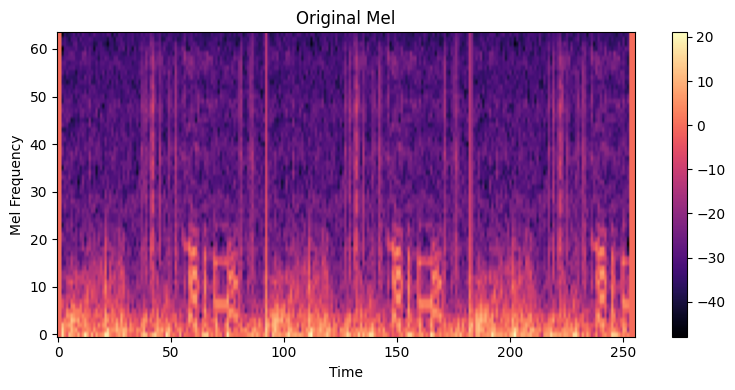

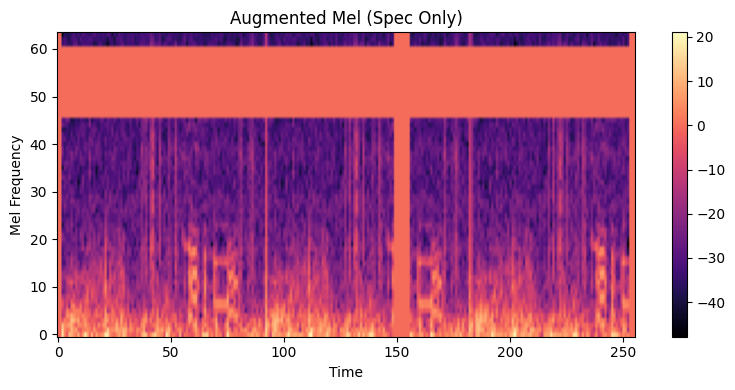

In [81]:
import matplotlib.pyplot as plt

# 데이터 로드
mel = train_dataset[0][0]  # (1, 64, 256)

# 증강 적용
aug_speconly, _ , _ = aug(mel)  # aug1: speconly, aug2: speconly

# 시각화 함수
def show_mel(mel_tensor, title):
    # 텐서 shape이 (1, 64, 256) 또는 (1, 1, 64, 256)일 수 있음
    if mel_tensor.ndim == 4:
        mel_tensor = mel_tensor.squeeze(0)  # (1, 64, 256)
    mel_np = mel_tensor.squeeze(0).cpu().numpy()  # (64, 256)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(mel_np, origin='lower', aspect='auto', cmap='magma')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()

# 시각화
show_mel(mel, "Original Mel")
show_mel(aug_speconly, "Augmented Mel (Spec Only)")


#### 2.4 DataLoader

In [82]:
train_dataset[0]

(tensor([[[  0.0000,   0.0000,  16.3263,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,  14.7998,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,  10.6989,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000, -33.8973,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000, -35.8268,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000, -45.6381,  ...,   0.0000,   0.0000,   0.0000]]]),
 tensor([0., 1.]),
 ('103_2b2_Ar_mc_LittC2SE', np.float64(2.886)))

In [83]:
train_dataset[9][0].shape

torch.Size([1, 64, 256])

In [84]:
# ---------------- 학습 데이터 구성(seed) ----------------
seed_everything(args.seed)

# train_dataset 내에서 각 파일의 인덱스를 추출
pretrain_idx = []
finetune_idx = []

for i in range(len(train_dataset)):
    filename = train_dataset[i][2][0]

    if filename in pretrain_list:
        pretrain_idx.append(i)
    # elif filename in finetune_list:
    #     finetune_idx.append(i)

    # pretrain = finetune
    if filename in finetune_list:
        finetune_idx.append(i)

# 인덱스 순서 셔플
random.shuffle(pretrain_idx)
random.shuffle(finetune_idx)

print(f"Pretrain set size: {len(pretrain_idx)}, Finetune set size: {len(finetune_idx)}")

Pretrain set size: 4142, Finetune set size: 4142


코드 실행 환경에 따라 num_workers를 적절한 값으로 지정해주세요!

In [85]:
# Dataset 생성 (Subset)
pretrain_dataset = Subset(train_dataset, pretrain_idx)
finetune_dataset = Subset(train_dataset, finetune_idx)

# DataLoader 생성
# DataLoader에서 shuffle=True로 지정하면 매 epoch마다 셔플 순서가 달라짐 => 재현성 문제 발생
# pretrain_dataset, finetune_dataset은 이미 셔플이 완료된 것으로, 이것을 DataLoader에 입력함
pretrain_loader = DataLoader(
    pretrain_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    shuffle=False
)

finetune_loader = DataLoader(
    finetune_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    pin_memory=True,
    shuffle=False
)

label 분포 확인 (단순 참고용, 실제 환경에서는 pretrain set의 label 분포가 어떤지 알 수 없음)

In [86]:
from collections import Counter

# label
labels = torch.stack([multi_label for _, multi_label, _ in train_dataset])

# pretext와 finetune 데이터셋의 라벨 분포 출력
pretrain_labels = labels[pretrain_idx]
pretrain_labels_class = (
    pretrain_labels[:, 0].long() * 1 +  # crackle bit → *1
    pretrain_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}
finetune_labels = labels[finetune_idx]
finetune_labels_class = (
    finetune_labels[:, 0].long() * 1 +  # crackle bit → *1
    finetune_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

# test 데이터셋의 라벨 분포 출력
test_labels = torch.stack([multi_label for _, multi_label, _ in test_dataset])
test_labels_class = (
    test_labels[:, 0].long() * 1 +  # crackle bit → *1
    test_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

print(f"Pretrain sample: {len(pretrain_labels_class)}")
print("Pretrain label distribution:", Counter(pretrain_labels_class.tolist()))
print(f"\nFinetune sample: {len(finetune_labels_class)}")
print("Finetune label distribution:", Counter(finetune_labels_class.tolist()))
print(f"Test sample: {len(test_labels_class)}")
print("Test label distribution:", Counter(test_labels_class.tolist()))

Pretrain sample: 4142
Pretrain label distribution: Counter({0: 2063, 1: 1215, 2: 501, 3: 363})

Finetune sample: 4142
Finetune label distribution: Counter({0: 2063, 1: 1215, 2: 501, 3: 363})
Test sample: 2756
Test label distribution: Counter({0: 1579, 1: 649, 2: 385, 3: 143})


## 3. Modeling

#### 3.1 Pre-trained ResNet50

In [87]:
# def backbone_resnet():
#     # 1. 기본 ResNet50 생성 (pretrained=False로 시작)
#     resnet = models.resnet50(pretrained=False)

#     # 2. 첫 번째 conv 레이어를 1채널용으로 수정
#     resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

#     # 먼저 fc 제거
#     resnet.fc = nn.Identity()

#     # 3. ImageNet 가중치 로드 (conv1 제외)
#     state_dict = load_state_dict_from_url(
#         'https://download.pytorch.org/models/resnet50-19c8e357.pth',
#         progress=True
#     )
#     if 'conv1.weight' in state_dict:
#         del state_dict['conv1.weight']
#     resnet.load_state_dict(state_dict, strict=False)

#     return resnet

In [88]:
from torchvision.models import resnet50, ResNet50_Weights

class ResNet50(torchvision.models.resnet.ResNet):
    def __init__(self, track_bn=True):
        def norm_layer(*args, **kwargs):
            return nn.BatchNorm2d(*args, **kwargs, track_running_stats=track_bn)
        super().__init__(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], norm_layer=norm_layer)
        del self.fc
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.final_feat_dim = 2048

    def load_sl_official_weights(self, progress=True):
        weights = ResNet50_Weights.DEFAULT
        state_dict = weights.get_state_dict(progress=progress)

        del state_dict['conv1.weight']
        missing, unexpected = self.load_state_dict(state_dict, strict=False)
        # if len(missing) > 0:
            # raise AssertionError('Model code may be incorrect')

    def load_ssl_official_weights(self, progress=True):
        # only SimCLR is available
        from pl_bolts.models.self_supervised import SimCLR
        
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
        simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)

        state_dict = {}
        for k, v in simclr.state_dict().items():
            if 'encoder.' in k:
                k = k.replace('encoder.', '')
            if 'fc' not in k or 'project' not in k:
                state_dict[k] = v
        missing, unexpected = self.load_state_dict(state_dict, strict=False)
        # non_linear_evaluator.block_forward is a pretrained MLP classifier for SimCLR
        # refer to https://github.com/Lightning-AI/lightning-bolts/blob/bcbbf6ab6c36430946dd8a416ddc7e697e8507fc/pl_bolts/models/self_supervised/evaluator.py#L7
        if len(missing) > 0:
            raise AssertionError('Model code may be incorrect')

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # x = self.fc(x)

        return x

In [89]:
def backbone_resnet50_patch():
    """
    MoCo 구조에 사용할 CNN6 백본 정의 함수.
    
    주요 변경 사항:
    - ResNet50 대신 CNN6 클래스 사용
    - 출력 feature dim은 512로 고정됨 (MoCo에서는 dim_enc=2048 → 이 부분만 맞춰서 사용하면 문제 없음)
    - ImageNet pretrained 사용 대신 공식 CNN6 pretrained 로딩 함수 포함 (옵션 사용 가능)
    """
    model = ResNet50()

    # 공식 SL pretrained weight를 사용하고자 할 경우 아래 줄을 주석 해제
    model.load_sl_official_weights()

    return model


#### 3.2 Pre-trained CNN6

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """
    nn.init.xavier_uniform_(layer.weight)
    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
            

def init_bn(bn):
    """Initialize a Batchnorm layer. """
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)


class ConvBlock5x5(nn.Module): #for CNN6
    def __init__(self, in_channels, out_channels, stride=(1,1)):
        
        super(ConvBlock5x5, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(5, 5), stride=stride,
                              padding=(2, 2), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.init_weight()
        
    def init_weight(self):
        init_layer(self.conv1)
        init_bn(self.bn1)
        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')
        
        return x


class CNN6(nn.Module):
    def __init__(self):
        super(CNN6, self).__init__()
        self.final_feat_dim = 512

        self.do_dropout = False
        self.conv_block1 = ConvBlock5x5(in_channels=1, out_channels=64, stride=(1,1))
        self.conv_block2 = ConvBlock5x5(in_channels=64, out_channels=128, stride=(1,1))
        self.conv_block3 = ConvBlock5x5(in_channels=128, out_channels=256, stride=(1,1))
        self.conv_block4 = ConvBlock5x5(in_channels=256, out_channels=512, stride=(1,1))
        self.dropout = nn.Dropout(0.2)
        # self.linear = nn.Linear(512, num_classes, bias=True)

    def load_sl_official_weights(self):
        """ download AudioSet pretrained CNN6 in https://zenodo.org/record/3960586#.Y8dz8y_kEiY
        """
        weights = torch.load('/home/HyeonSeok/Cnn6_mAP=0.343.pth')['model']
        state_dict = {k: v for k, v in weights.items() if k in self.state_dict().keys()}
        missing, unexpected = self.load_state_dict(state_dict, strict=False)

    def forward(self, x, return_feature_map=False):
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        
        if return_feature_map:
            return x  # shape: (B, 512, 4, 16)

        x = torch.mean(x, dim=3) #mean over time dim
        (x1, _) = torch.max(x, dim=2) #max over freq dim
        x2 = torch.mean(x, dim=2) #mean over freq dim (after mean over time)
        x = x1 + x2

        # if self.embed_only:
        #     return x
        # return self.linear(x)
        return x

In [91]:
def backbone_cnn6():
    """
    MoCo 구조에 사용할 CNN6 백본 정의 함수.
    
    주요 변경 사항:
    - ResNet50 대신 CNN6 클래스 사용
    - 출력 feature dim은 512로 고정됨 (MoCo에서는 dim_enc=2048 → 이 부분만 맞춰서 사용하면 문제 없음)
    - ImageNet pretrained 사용 대신 공식 CNN6 pretrained 로딩 함수 포함 (옵션 사용 가능)
    """
    model = CNN6()

    # 공식 SL pretrained weight를 사용하고자 할 경우 아래 줄을 주석 해제
    model.load_sl_official_weights()

    return model


##### Multilabel Attention

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MultilabelAttention(nn.Module):
    def __init__(self, backbone, num_classes=2, lambda_attn=0.5, attention_heads=[1, float('inf')]):
        super(MultilabelAttention, self).__init__()
        self.backbone = backbone()
        self.num_classes = num_classes
        self.lambda_attn = lambda_attn
        self.attention_heads = attention_heads  # e.g., [1, inf] for H=2

        self.class_weights = nn.Parameter(torch.randn(len(attention_heads), num_classes, 512))

        self.output_layer = nn.ModuleList([
            nn.Linear(512, 1) for _ in range(num_classes)
        ])

    def forward(self, x):
        # CNN6 백본 통과 → shape: (B, 512, 4, 16)
        feat_map = self.backbone(x, return_feature_map=True)  # (B, 512, 4, 16)

        B, C, Freq, Time = feat_map.shape
        flat_feat = feat_map.view(B, C, Freq * Time).permute(0, 2, 1)  # (B, 64, 512)

        # Class-specific attention a_i 계산
        attn_outputs = []
        for h, T in enumerate(self.attention_heads):
            Ci = self.class_weights[h]  # (num_classes, 512)
            logits = torch.einsum("bnc, kc -> bnk", flat_feat, Ci)  # (B, 64, num_classes)
            logits = logits.permute(0, 2, 1)  # (B, num_classes, 64)
            if T == float('inf'):
                attn_scores = F.one_hot(torch.argmax(logits, dim=2), num_classes=logits.shape[2]).float()
            else:
                attn_scores = F.softmax(T * logits, dim=2)  # (B, num_classes, 64)

            attn_scores = attn_scores.unsqueeze(-1)  # (B, num_classes, 64, 1)
            flat_feat_exp = flat_feat.unsqueeze(1)  # (B, 1, 64, 512)
            attn_feat = torch.sum(attn_scores * flat_feat_exp, dim=2)  # (B, num_classes, 512)
            attn_outputs.append(attn_feat)

        # Class-specific global feature g_i 계산
        feat_avg_t = torch.mean(feat_map, dim=3)  # (B, 512, Freq)
        gmp = torch.max(feat_avg_t, dim=2)[0]     # (B, 512)
        gap = torch.mean(feat_avg_t, dim=2)       # (B, 512)
        g = gmp + gap                             # (B, 512)
        g = g.unsqueeze(1).repeat(1, self.num_classes, 1)  # (B, num_classes, 512)

        # Combine: f_i = g_i + lambda * a_i
        combined = g
        for attn in attn_outputs:
            combined = combined + self.lambda_attn * attn  # sum over heads

        # Output layer for each class
        out = []
        for i in range(self.num_classes):
            cls_feat = combined[:, i, :]  # (B, 512)
            logit = self.output_layer[i](cls_feat).squeeze(-1)  # (B,)
            out.append(logit)

        logits = torch.stack(out, dim=1)  # (B, num_classes)
        probs = torch.sigmoid(logits)    # (B, num_classes)
        return combined, logits, probs                 # 마지막 dim: (B, 2, 512) 


def backbone_mlattention():
    """
    Multi-label attention 기반 backbone 정의 함수
    CNN6 기반 특징 추출기 + CSRA 기반 attention 구조 결합
    
    Returns:
        nn.Module: Multi-label attention 기반 분류기
    """
    return MultilabelAttention(backbone=backbone_cnn6, num_classes=2, lambda_attn=0.5, attention_heads=[1, float('inf')])


In [93]:
x = torch.randn(10, 1, 64, 256) # B=10
model = backbone_mlattention()
out = model(x)  # (B, 2, 512)

print(out[0].shape)  # → torch.Size([B=10, 2, 512])

torch.Size([10, 2, 512])


In [94]:
# summary 함수 사용: (채널, 높이, 너비) 크기를 지정
summary(backbone_mlattention().to(device), input_size=(1, 64, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 256]           1,600
       BatchNorm2d-2          [-1, 64, 64, 256]             128
      ConvBlock5x5-3          [-1, 64, 32, 128]               0
            Conv2d-4         [-1, 128, 32, 128]         204,800
       BatchNorm2d-5         [-1, 128, 32, 128]             256
      ConvBlock5x5-6          [-1, 128, 16, 64]               0
            Conv2d-7          [-1, 256, 16, 64]         819,200
       BatchNorm2d-8          [-1, 256, 16, 64]             512
      ConvBlock5x5-9           [-1, 256, 8, 32]               0
           Conv2d-10           [-1, 512, 8, 32]       3,276,800
      BatchNorm2d-11           [-1, 512, 8, 32]           1,024
     ConvBlock5x5-12           [-1, 512, 4, 16]               0
             CNN6-13           [-1, 512, 4, 16]               0
           Linear-14                   

#### 3.2 MoCo (MLS)

## 4. Training

In [95]:
next(iter(pretrain_loader))[0].shape

torch.Size([128, 1, 64, 256])

In [96]:
def validate(model, val_loader, criterion, device):
    """
    Multi-label (2-hot) → Multi-class (0~3)로 변환하여 평가
    - 입력 shape: inputs [B, C, H, W], labels [B, 2]
    - 출력 shape: preds [N, 2], labels [N, 2]
    - 최종 multi-class 평가: (0=Normal, 1=Crackle, 2=Wheeze, 3=Both)
    """
    import numpy as np

    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            output = model(inputs)
            if isinstance(output, (tuple, list)):  # (ex: (_, output, _))
                output = output[1]
            # output shape: [B, num_classes] (ex. [32, 2])
            # criterion expects same shape
            loss = criterion(output, labels)
            running_loss += loss.item()

            # multi-label prediction (threshold=0.5)
            preds = (torch.sigmoid(output) > 0.5).int()   # [B, 2]
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()   # [N, 2]
    all_labels = torch.cat(all_labels, dim=0).numpy() # [N, 2]

    avg_loss = running_loss / len(val_loader)

    # return shape: (float, [N,2], [N,2])
    return avg_loss, all_labels, all_preds


In [97]:
import torch
import numpy as np

def patch_mix_mel(mel, labels, beta=2.0):
    """
    mel 이미지의 시간 축을 20ms 단위(2프레임)로 자르고 일부를 다른 샘플과 교환
    mel: [B, 1, 64, 256] expected (4D tensor)
    labels: [B, C] (multi-label)
    
    Returns:
        mixed_mel: patch-mixed mel spectrograms (same shape as input)
        labels_a: 원본 라벨
        labels_b: 섞인 대상 라벨
        lam: 혼합 비율 (Beta 분포에서 샘플)
        index: 섞인 인덱스 (contrastive loss 등에서 사용 가능)
    """
    # === 입력 형태 확인 ===
    if mel.ndim == 5 and mel.shape[1] == 1:
        # [B, 1, 1, H, W] 같은 형태일 경우 squeeze
        mel = mel.squeeze(1)
    if mel.ndim != 4:
        raise ValueError(f"Expected 4D mel input (B, C, H, W), got {mel.shape}")
    
    B, C, H, W = mel.shape
    if W % 2 != 0:
        raise ValueError(f"Time axis (W={W}) must be divisible by 2 for 20ms patches.")

    # === Beta 분포에서 lambda 샘플링 ===
    lam = np.random.beta(beta, beta)
    index = torch.randperm(B).to(mel.device)

    # === 시간축 2프레임 단위 patch 분할 및 재구성 ===
    N = W // 2
    patches = mel.view(B, C, H, N, 2).permute(0, 3, 1, 2, 4)  # [B, N, C, H, 2]

    # === 일부 patch 교환 ===
    num_swap = int(N * (1 - lam))
    if num_swap > 0:
        patch_idx = torch.randperm(N)[:num_swap]
        patches[:, patch_idx] = patches[index][:, patch_idx]  # 다른 샘플로 교체

    # === 원래 mel 형태로 복원 ===
    mixed_mel = patches.permute(0, 2, 3, 1, 4).reshape(B, C, H, W)

    # === 라벨 쌍 반환 (loss 계산 시 soft mix or lam-weighted loss 적용)
    labels_a = labels
    labels_b = labels[index]

    return mixed_mel, labels_a, labels_b, lam, index


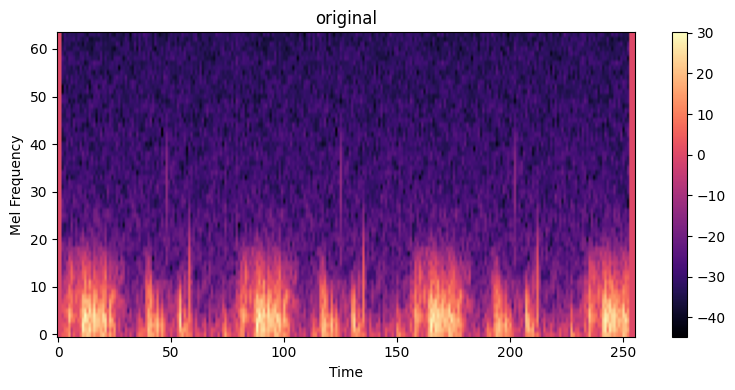

In [ ]:
show_mel(train_dataset[15][0], 'original')

In [98]:
batch_mel = next(iter(pretrain_loader))[0]
batch_labels = next(iter(pretrain_loader))[1]

In [106]:
B = batch_mel.shape[0]

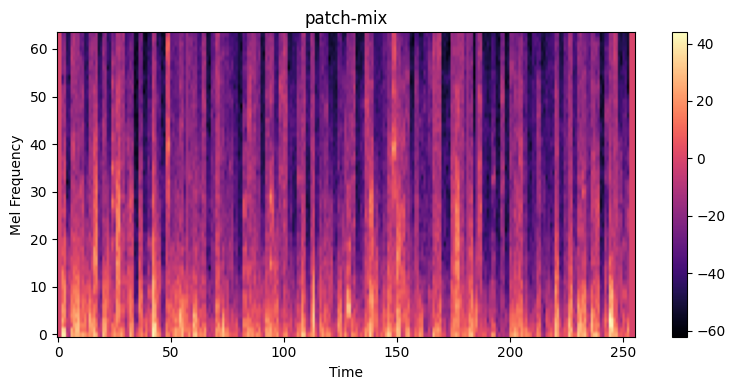

In [125]:
show_mel(patch_mix_mel(batch_mel, batch_labels)[0][15],'patch-mix')

In [ ]:
for i in range(B):
    show_mel(patch_mix_mel(batch_mel, batch_labels)[0][i],'mel')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchMixContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.06):
        super().__init__()
        self.temperature = temperature

    def forward(self, z_mixed, z_orig, lam, index):
        """
        z_mixed: [B, D] - mixed representations
        z_orig:  [B, D] - original representations
        index: permutation index used in PatchMix
        lam: lambda coefficient from beta distribution
        """
        B = z_mixed.size(0)

        # Positive targets: two sources
        pos_1 = z_orig          # original A
        pos_2 = z_orig[index]  # original B

        # Numerator: weighted similarity to two positives
        sim_pos1 = torch.sum(z_mixed * pos_1, dim=-1) / self.temperature
        sim_pos2 = torch.sum(z_mixed * pos_2, dim=-1) / self.temperature

        numerator = lam * torch.exp(sim_pos1) + (1 - lam) * torch.exp(sim_pos2)

        # Denominator: similarities to all in batch
        logits = torch.matmul(z_mixed, z_orig.T) / self.temperature
        denominator = torch.exp(logits).sum(dim=1)

        loss = -torch.log((numerator + 1e-8) / (denominator + 1e-8)).mean()
        return loss
cl_criterion = PatchMixContrastiveLoss(temperature=0.05).cuda()

In [ ]:
import os
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn

train_losses = []
test_losses = []
train_icbhi_scores = []
test_icbhi_scores = []
test_labels_all = []
test_preds_all = []
epochs = []

# 모델 지정하기 전 seed 고정 필요
seed_everything(args.seed) # Seed 고정

# for gam in [2.0,2.3,2.7,3.0]:

pretrain_project_name = f'MultilabelAtt_mix1_tau0.06_{args.batch_size}bs_{get_timestamp()}'

#-------------------------------------------wan
# wandb 초기화 (프로젝트명, 실험 이름 등 설정)
wandb.init(
    project="0721_SBW_ICBHI_MLATT_all", # 프로젝트 이름
    name=f"{pretrain_project_name}",  # 실험 이름
    config={
        "epochs": args.epochs,
        "batch_size": args.batch_size,
        "lr": args.lr,
        "momentum": args.momentum,
        "weight_decay": args.weight_decay
    }
)
#-------------------------------------------wan


# 1. MoCo 모델 생성
model = MultilabelAttention(
    backbone=backbone_cnn6, 
    num_classes=2, lambda_attn=0.5, 
    attention_heads=[1, float('inf')]
).cuda()

# model = MultilabelMoCo(
#     base_encoder = backbone_mlattention,
#     dim_enc = 512, # CNN6의 출력 feature dim (default=2048)
#     dim_prj = args.dim_prj,
#     K = args.K,
#     m = args.momentum,
#     T = args.T,
#     top_k = args.top_k,
#     lambda_bce = args.lambda_bce
# ).cuda()

# 2. Optimizer
# optimizer = torch.optim.AdamW(model.parameters(), args.lr, weight_decay=args.weight_decay)
optimizer = torch.optim.Adam(model.parameters(), args.lr) # weight_decay=args.weight_decay

# 3. Cosine Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=1e-6)

# 4. Loss Function
criterion = nn.BCEWithLogitsLoss()

# 5. Train
alpha = 0.2 # Contrastive loss 가중치

# Best loss 초기화
best_loss = float('inf')
best_epoch = -1

def multilabel_to_multiclass(y):
    # Crackle → 1, Wheeze → 2, Both → 3, None → 0
    y = np.array(y)
    return y[:, 0] + y[:, 1] * 2

# projector
projector = nn.Sequential(
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128)
).cuda()


for epoch in range(args.epochs):
    # ===============================
    # Training
    # ===============================
    model.train()
    projector.train()
    total_train_loss = 0.0

    all_preds = []
    all_labels = []
    all_outputs = []

    pbar = tqdm(pretrain_loader, desc=f'Epoch {epoch} - PatchMix CE+CL')
    for i, (repeat_mel, label, _) in enumerate(pbar):
        # === 1. Input ===
        mel = repeat_mel.float().cuda(device=args.gpu, non_blocking=True)  # [B, 1, 64, 256]
        label = label.cuda(args.gpu)

        # === 2. PatchMix ===
        mixed_mel, label_a, label_b, lam, index = patch_mix_mel(mel, label, beta=1.0)

        # === 3. Forward ===
        optimizer.zero_grad()

        feats, output, _ = model(mixed_mel)             # feats: [B, 2, 512], output: [B, 2]
        z_mixed = projector(feats.mean(dim=1))          # [B, 512] → [B, proj_dim]

        # === 4. BCE Loss ===
        loss_ce = lam * criterion(output, label_a) + (1 - lam) * criterion(output, label_b)

        # === 5. Contrastive Loss ===
        with torch.no_grad():
            feats_orig, _, _ = model(mel)
            z_orig = projector(feats_orig.mean(dim=1))

        z_mixed = F.normalize(z_mixed, dim=-1)
        z_orig = F.normalize(z_orig, dim=-1)

        loss_cl = cl_criterion(z_mixed, z_orig, lam, index)  # custom contrastive loss

        # === 6. Total Loss ===
        total_loss = loss_ce + alpha * loss_cl
        total_loss.backward()
        optimizer.step()

        total_train_loss += total_loss.item()

        # === 7. 예측 저장 ===
        predicted = (torch.sigmoid(output) > 0.5).float()
        all_preds.append(predicted.detach().cpu())
        all_labels.append(label.detach().cpu())
        all_outputs.append(output.detach().cpu())

    # === 8. Epoch 마무리 ===
    train_loss = total_train_loss / len(pretrain_loader)
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_output = torch.cat(all_outputs, dim=0).numpy()

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f}, mixed_mel shape: {mixed_mel.shape}")



    # =====================================
    # 2-Edited. Multi-class 민감도/특이도 계산
    # =====================================
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import wandb
    from sklearn.metrics import confusion_matrix

    def multilabel_to_multiclass(y):
        # Crackle → 1, Wheeze → 2, Both → 3, None → 0
        y = np.array(y)
        return y[:, 0] + y[:, 1]*2

    def evaluate_multiclass_confusion(y_true, y_pred, class_names=["Normal", "Wheeze", "Crackle", "Both"]):
        y_true_cls = multilabel_to_multiclass(y_true)
        y_pred_cls = multilabel_to_multiclass(y_pred)

        cm = confusion_matrix(y_true_cls, y_pred_cls, labels=[0, 1, 2, 3])

        # N_n: 정상 → 정상
        N_n = cm[0, 0]
        N_total = cm[0].sum()

        # 이상 클래스 정답 수: W, C, B
        W_total = cm[1].sum()
        C_total = cm[2].sum()
        B_total = cm[3].sum()

        # 각각의 정답 → 정확한 예측만 고려
        W_w = cm[1, 1]
        C_c = cm[2, 2]
        B_b = cm[3, 3]

        SP = N_n / (N_total + 1e-6) #spec
        SE = (W_w + C_c + B_b) / (W_total + C_total + B_total + 1e-6) #sense

        AS = (SP + SE) / 2
        HS = 2 * SP * SE / (SP + SE + 1e-6)

        return cm, SE, SP, y_true_cls, y_pred_cls

    def log_multiclass_conf_matrix_wandb(cm, class_names, sens, spec, normalize, tag):
        # Normalize (비율) 옵션
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
            fmt = '.2f'
            title = "Confusion Matrix (Normalized %)"
        else:
            fmt = 'd'
            title = "Confusion Matrix (Raw Count)"

        fig, ax = plt.subplots(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, ax=ax)

        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(title)

        icbhi_score = (sens + spec) / 2
        # 우하단에 성능 출력
        ax.text(
            0.99, 0.15,
            f"Sensitivity: {sens*100:.2f}%\nSpecificity: {spec*100:.2f}%\nICBHI Score: {icbhi_score*100:.2f}%",
            ha='right', va='bottom',
            transform=plt.gca().transAxes,
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
        )

        plt.tight_layout()
        # wandb.log({tag: wandb.Image(fig)})
        # plt.close(fig)
        return fig

    # 1. 4-class Confusion Matrix 평가
    class_names = ["Normal", "Crackle", "Wheeze", "Both"]
    cm_4x4, train_sens, train_spec, y_true_cls, y_pred_cls = evaluate_multiclass_confusion(all_labels, all_preds, class_names)
    icbhi_score = (train_sens + train_spec)/2

    print("4-Class Confusion Matrix:\n", cm_4x4)
    print(f"Sensitivity: {train_sens:.4f}, Specificity: {train_spec:.4f}, ICBHI Score: {icbhi_score:.4f}")


    # ===============================
    # 3. Validation
    # ===============================
    test_loss, test_labels, test_preds = validate(
        model, test_loader, criterion, device
    )

    precision = precision_score(test_labels, test_preds, average='macro')
    recall = recall_score(test_labels, test_preds, average='macro')
    f1 = f1_score(test_labels, test_preds, average='macro')

    test_cm_4x4, test_sens, test_spec, test_y_true_cls, test_y_pred_cls = evaluate_multiclass_confusion(test_labels, test_preds)
    test_icbhi_score = (test_sens+test_spec)/2

    print("[Validation] Confusion Matrix:\n", test_cm_4x4)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"[VALIDATION] Sensitivity: {test_sens:.4f}, Specificity: {test_spec:.4f}, Avg ICBHI Score: {(test_sens+test_spec)/2:.4f}")
    print("##################################################")


    # ===============================
    # 4. Confusion Matrix
    # ===============================

    # 2. Finetune Count Confusion Matrix 시각화
    fig_finetune_raw = log_multiclass_conf_matrix_wandb(cm_4x4, class_names, train_sens, train_spec, normalize=False, tag="Training_conf_matrix_raw")
    fig_finetune_norm = log_multiclass_conf_matrix_wandb(cm_4x4, class_names, train_sens, train_spec, normalize=True, tag="Training_conf_matrix_norm")

    # 3. Test Confusion Matrix 시각화
    fig_test_raw = log_multiclass_conf_matrix_wandb(test_cm_4x4, class_names, test_sens, test_spec, normalize=False, tag="test_conf_matrix_raw")
    fig_test_norm = log_multiclass_conf_matrix_wandb(test_cm_4x4, class_names, test_sens, test_spec, normalize=True, tag="test_conf_matrix_norm")

    # 4. log dictionary 생성 -------------------------------------------wan
    wandb_log_dict = {
        "finetune_conf_matrix_raw": wandb.Image(fig_finetune_raw),
        "finetune_conf_matrix_norm": wandb.Image(fig_finetune_norm),
        "test_conf_matrix_raw": wandb.Image(fig_test_raw),
        "test_conf_matrix_norm": wandb.Image(fig_test_norm)
    }
    # -------------------------------------------wan

    # =====================================
    # 5. Checkpoint (Every 100 epochs)
    # =====================================
    if (epoch + 1) % 100 == 0:
        ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_{epoch:03d}.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, ckpt_path)
        print(f"💾 Saved checkpoint to {ckpt_path}")

    # ===============================
    # 6. Save Best Checkpoint
    # ===============================
    if test_loss < best_loss:
        best_loss = test_loss
        best_epoch = epoch
        best_ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_best.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': best_loss
        }, best_ckpt_path)
        print(f"=> Saved best checkpoint (epoch: {epoch}, loss: {best_loss:.4f})")


        # 🔹 Confusion Matrix Logging for Best
        cm_best, sens_best, spec_best,_, _ = evaluate_multiclass_confusion(test_labels, test_preds, class_names)
        fig_best_raw = log_multiclass_conf_matrix_wandb(cm_best, class_names, sens_best, spec_best, normalize=False, tag="best_test_conf_matrix_raw")

        fig_best_norm = log_multiclass_conf_matrix_wandb(cm_best, class_names, sens_best, spec_best, normalize=True, tag="best_test_conf_matrix_norm")

        # -------------------------------------------wan
        wandb_log_dict.update({
            "best_test_conf_matrix_raw": wandb.Image(fig_best_raw),
            "best_test_conf_matrix_norm": wandb.Image(fig_best_norm)
        })
        # -------------------------------------------wan


    if epoch == args.ft_epochs - 1:
        # 🔸 Confusion Matrix Logging for Last Epoch
        cm_last, sens_last, spec_last, _, _  = evaluate_multiclass_confusion(test_labels, test_preds, class_names)
        fig_last_raw = log_multiclass_conf_matrix_wandb(cm_last, class_names, sens_last, spec_last, normalize=False, tag="last_test_conf_matrix_raw")

        fig_last_norm = log_multiclass_conf_matrix_wandb(cm_last, class_names, sens_last, spec_last, normalize=True, tag="last_test_conf_matrix_norm")

        # -------------------------------------------wan
        wandb_log_dict.update({
            "last_test_conf_matrix_raw": wandb.Image(fig_last_raw),
            "last_test_conf_matrix_norm": wandb.Image(fig_last_norm)
        })
        # -------------------------------------------wan

    # =====================================
    # 7. Logging with wandb confusion matrix
    # =====================================

    # -------------------------------------------wan
    # step 1. metrics
    wandb.log({
        # Train metrics
        "Training/epoch": epoch,
        "Training/train_loss": train_loss,
        "Training/test_loss": test_loss,
        "Training/train_sens": train_sens,
        "Training/train_spec": train_spec,
        "Training/icbhi_score": icbhi_score,

        # Test metrics
        "Test/loss": test_loss,
        "Test/sensitivity": test_sens,
        "Test/specificity": test_spec,
        "Test/icbhi_score": test_icbhi_score
    })

    # step 2. Confusion matrix
    wandb.log(wandb_log_dict)

    # -------------------------------------------wan


    plt.close(fig_finetune_raw)
    plt.close(fig_finetune_norm)
    plt.close(fig_test_raw)
    plt.close(fig_test_norm)
    if 'fig_best_raw' in locals(): plt.close(fig_best_raw)
    if 'fig_best_norm' in locals(): plt.close(fig_best_norm)
    if 'fig_last_raw' in locals(): plt.close(fig_last_raw)
    if 'fig_last_norm' in locals(): plt.close(fig_last_norm)

    # ===============================
    # 8. Scheduler Step
    # ===============================
    scheduler.step()

    # ===============================
    # 9. Save Metrics
    # ===============================
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_icbhi_scores.append(icbhi_score)
    test_icbhi_scores.append(test_icbhi_score)
    epochs.append(epoch)
    # ================================

    # ================================
    # test_labels_all, test_preds_all에 저장
    # ================================
    test_labels_all.append(test_labels)
    test_preds_all.append(test_preds)
    # ================================


# -------------------------------------------wan
wandb.finish()
#-------------------------------------------wan

/var/tmp/ipykernel_8532/1685729402.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('/home/gracesung007/BOAZ-Chungzins/models/Cnn6_mAP=0.343.pth')['

[Epoch 0] Train Loss: 0.8371, mixed_mel shape: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1805  172   63    4]
 [ 970  190   36    3]
 [ 442   35   15    1]
 [ 306   46    8    0]]
Sensitivity: 0.0999, Specificity: 0.8831, ICBHI Score: 0.4915
[Validation] Confusion Matrix:
 [[1034  350  195    0]
 [ 332  301   16    0]
 [ 219   76   89    1]
 [  85   34   24    0]]
Test Loss: 0.5422
[VALIDATION] Sensitivity: 0.3314, Specificity: 0.6548, Avg ICBHI Score: 0.4931
##################################################
=> Saved best checkpoint (epoch: 0, loss: 0.5422)


Epoch 1 - PatchMix CE+CL: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


[Epoch 1] Train Loss: 0.7097, mixed_mel shape: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1551  405   85    3]
 [ 685  459   54    1]
 [ 275   66  151    1]
 [ 193  108   54    5]]
Sensitivity: 0.2997, Specificity: 0.7588, ICBHI Score: 0.5293
[Validation] Confusion Matrix:
 [[995 259 325   0]
 [379 242  27   1]
 [195  71 118   1]
 [ 75  31  36   1]]
Test Loss: 0.5957
[VALIDATION] Sensitivity: 0.3067, Specificity: 0.6301, Avg ICBHI Score: 0.4684
##################################################


Epoch 2 - PatchMix CE+CL: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


[Epoch 2] Train Loss: 0.6582, mixed_mel shape: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1559  369  100   16]
 [ 628  511   54    6]
 [ 248   52  183   10]
 [ 151  107   84   18]]
Sensitivity: 0.3470, Specificity: 0.7627, ICBHI Score: 0.5548


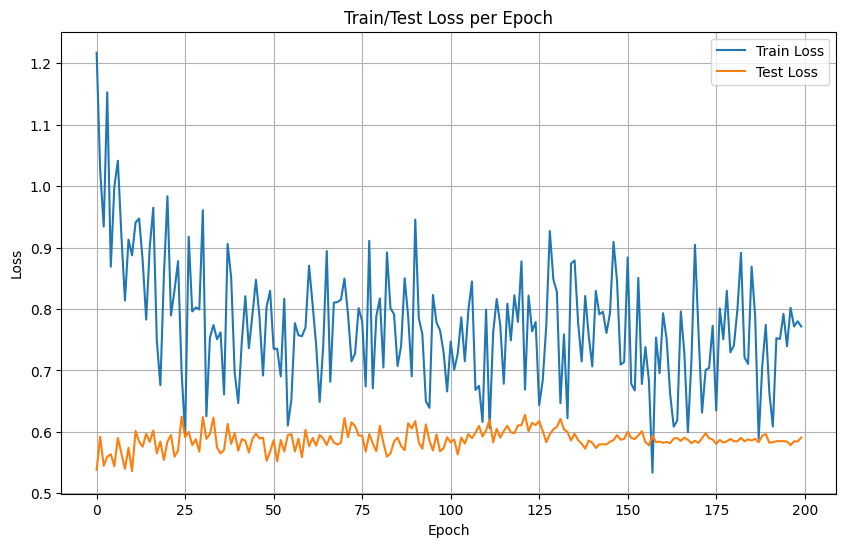

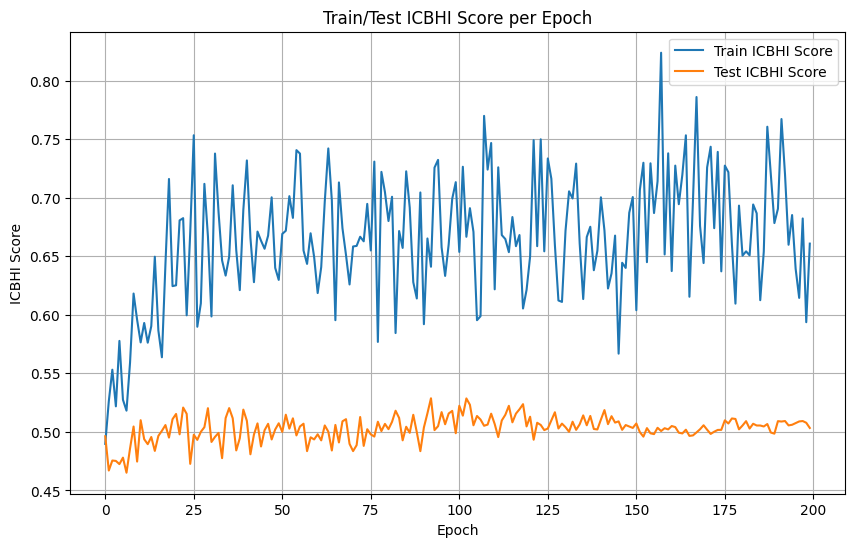


=== [최고 Test ICBHI Score 시점 정보] ===
Best Test ICBHI Score: 0.5288 (Epoch 92)
Test Loss at Best: 0.5725
Confusion Matrix at Best ICBHI Score:
[[1101  241  222   15]
 [ 344  274   22    9]
 [ 170   65  126   24]
 [  62   24   33   24]]
Sensitivity: 0.3602, Specificity: 0.6973, ICBHI Score: 0.5288
Best Epoch: 92


In [ ]:
# --- 훈련 종료 후 그래프 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(epochs, train_icbhi_scores, label='Train ICBHI Score')
plt.plot(epochs, test_icbhi_scores, label='Test ICBHI Score')
plt.xlabel('Epoch')
plt.ylabel('ICBHI Score')
plt.title('Train/Test ICBHI Score per Epoch')
plt.legend()
plt.grid(True)
plt.show()

best_epoch_idx = np.argmax(test_icbhi_scores)
best_epoch = epochs[best_epoch_idx]
best_icbhi_score = test_icbhi_scores[best_epoch_idx]
best_test_loss = test_losses[best_epoch_idx]

# 최고점 epoch에서의 labels, preds
best_test_labels = test_labels_all[best_epoch_idx]
best_test_preds = test_preds_all[best_epoch_idx]

best_cm, best_sens, best_spec, best_y_true_cls, best_y_pred_cls = evaluate_multiclass_confusion(
    best_test_labels, best_test_preds)

print("\n=== [최고 Test ICBHI Score 시점 정보] ===")
print(f"Best Test ICBHI Score: {best_icbhi_score:.4f} (Epoch {best_epoch})")
print(f"Test Loss at Best: {best_test_loss:.4f}")
print("Confusion Matrix at Best ICBHI Score:")
print(best_cm)
print(f"Sensitivity: {best_sens:.4f}, Specificity: {best_spec:.4f}, ICBHI Score: {(best_sens+best_spec)/2:.4f}")
print(f"Best Epoch: {best_epoch}")
